# Load Sentinel 2 chips

## Input Data

The input data for loading are the image chips generated in the Jupyter Notebook *01.03-bm-chips-s2-planetary-computer-code*. This needs to run in Microsfts Planetary Computer.

Input data:
* *data\intermediate\chips\s2_metrics_p*
  * */data/{olc_id}.nc*: netcdf file with percentiles and mid 50 and mid 80 ranges
  * */metadata_s2_scenes/{olc_id}.csv*: metadata file listing the scenes found by the query and the scenes used to calculate the metrics, where the column *unique_metrics* is `True`

OR on S3
* s3://mi4people-soil-project/chips/s2_metrics_p/data
* s3://mi4people-soil-project/chips/s2_metrics_p/meatadata_s2_scenes


## Read chip data from S3

In [43]:
import sys
import os
sys.path.append("../") # go to parent dir
import pandas as pd
import numpy as np
import xarray as xr
from src.data import chips_loader


## Chips list

Get list of chip geometries.

In [44]:
# chips = chips_loader.ChipsReader(secrets_file_path="../.secrets/my_aws_accessKeys.csv")
chips = chips_loader.ChipsReader(secrets_file_path=".secrets/my_aws_accessKeys.csv")
chips.gdf.head()

,olc_id,GID_0,latitude,longitude,chip_id,index_right,tile,zone_number,zone_letter,epsg,easting,northing,minx,miny,maxx,maxy,geometry
0,7C28GHFX+PFH,GIN,10.524305,-13.401268,22015,26200,28PFS,28,P,32628,674946.973256,1.163828e+06,674300.0,1163180.0,675590.0,1164470.0,"POLYGON ((-13.40721 10.51847, -13.40715 10.530..."
1,7C28GJC9+GVX,GIN,10.521368,-13.380262,22016,26200,28PFS,28,P,32628,677247.951929,1.163515e+06,676600.0,1162870.0,677890.0,1164160.0,"POLYGON ((-13.38621 10.51556, -13.38615 10.527..."
2,7C28FHCG+R93,GIN,10.472017,-13.424075,22019,26200,28PFS,28,P,32628,672479.666715,1.158032e+06,671830.0,1157390.0,673120.0,1158680.0,"POLYGON ((-13.43004 10.46624, -13.42998 10.477..."
3,7C28FHWH+W37,GIN,10.497298,-13.422322,22020,26200,28PFS,28,P,32628,672657.593188,1.160830e+06,672010.0,1160180.0,673300.0,1161470.0,"POLYGON ((-13.42827 10.49146, -13.42821 10.503..."
4,7C28GH98+GRR,GIN,10.518867,-13.432997,22021,26200,28PFS,28,P,32628,671477.168369,1.163209e+06,670830.0,1162560.0,672120.0,1163850.0,"POLYGON ((-13.43894 10.51303, -13.43888 10.524..."


## Chip

Get a specific chip.

In [45]:
# chip = chips.get_chip("7C28FHWH+W37")
chip = chips.get_chip("7C28GHFX+PFH")
chip.data

<xarray.Dataset>
Dimensions:      (x: 129, y: 129, metric: 7, time_period: 2)
Coordinates:
  * x            (x) float64 6.743e+05 6.743e+05 ... 6.756e+05 6.756e+05
  * y            (y) float64 1.164e+06 1.164e+06 ... 1.163e+06 1.163e+06
  * metric       (metric) object 'p010' 'p025' 'p050' ... 'pmid50' 'pmid80'
  * time_period  (time_period) object 'season_1' 'season_2'
    spatial_ref  int32 ...
Data variables:
    B02          (time_period, y, x, metric) int16 ...
    B04          (time_period, y, x, metric) int16 ...
    B8A          (time_period, y, x, metric) int16 ...
    B09          (time_period, y, x, metric) int16 ...
    B11          (time_period, y, x, metric) int16 ...
    B12          (time_period, y, x, metric) int16 ...

In [46]:
def get_chip_dimensions(chip):
    img_shape = list(chip.data.dims[d] for d in ['x', 'y'])
    print('image size = ',img_shape)

    # specify no of bands and seasons in the image
    n_bands = len(list(chip.data.keys()))
    n_percentiles = chip.data.dims["metric"]
    n_seasons = chip.data.dims["time_period"]

    return img_shape, n_bands, n_percentiles, n_seasons

img_shape, n_bands, n_percentiles, n_seasons = get_chip_dimensions(chip=chip)


image size =  [129, 129]


In [47]:
def stack_chips_into_array(chip, img_shape, n_bands, n_percentiles, n_seasons):

    # 4 dimensional dummy array with zeros
    MB_img = np.zeros((img_shape[0],img_shape[1],n_bands,n_percentiles, n_seasons))
    MB_img.shape
    # stacking up images into the array
    i = 0
    for time_period in chip.data.time_period.values:
        j = 0
        for metric in chip.data.metric.values:
            k=0
            for band in list(chip.data.keys()):
                MB_img[:,:,k,j,i] = chip.data[band].sel(metric=metric, time_period=time_period)
                k+=1
            j += 1
        i+= 1
    return MB_img

MB_img = stack_chips_into_array(chip=chip, img_shape=img_shape, n_bands=n_bands, n_percentiles=n_percentiles, n_seasons=n_seasons)
MB_img.shape

(129, 129, 6, 7, 2)

### 1. Data Standardization

In [48]:
def convert_2d_band_array_to_1d_and_standardize(MB_img, n_bands, n_percentiles, n_seasons):
    # Convert 2d band array in 1-d to make them as feature vectors and Standardization
    MB_matrix = np.zeros((MB_img[:,:,0,0,0].size,n_bands,n_percentiles, n_seasons))

    for i in range (n_seasons):
        for j in range(n_percentiles):
            for k in range(n_bands):
                MB_array = MB_img[:,:,k,j,i].flatten()  # covert 2d to 1d array 
                MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
                MB_matrix[:,k,j,i] = MB_arrayStd
    return MB_matrix

MB_matrix = convert_2d_band_array_to_1d_and_standardize(MB_img, n_bands=n_bands, n_percentiles=n_percentiles, n_seasons=n_seasons)
MB_matrix.shape

(16641, 6, 7, 2)

### 2. PCA Transformation

In [49]:
# NOT NECESSARY??
def create_pcs_for_bands(MB_img, n_seasons, n_bands, n_percentiles):
    # Create PCs of bands for each percentile and season
    PCs = np.zeros((MB_img[:,:,0,0,0].size, n_bands, n_percentiles, n_seasons))

    for i in range (n_seasons):
        for j in range(n_percentiles):
            for k in range(n_bands):
                MB_array = MB_img[:,:,k,j,i].flatten()  # covert 2d to 1d array 
                MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
                PCs[:,k,j,i] = MB_arrayStd
    
    return PCs

# PCs = create_pcs_for_bands(MB_img=MB_img, n_seasons=n_seasons, n_bands=n_bands, n_percentiles=n_percentiles)
# PCs.shape

### 3. Eigenvalues and Vectors Computation

In [50]:
def create_eigvals(MB_matrix, n_bands, n_percentiles, n_seasons):

    EigVals = np.zeros((n_bands, n_percentiles, n_seasons))
    PCs = np.zeros((MB_matrix[:,0,0,0].size, n_bands, n_percentiles, n_seasons))

    for i in range (n_seasons):
        for j in range(n_percentiles):
            # Covariance
            np.set_printoptions(precision=n_bands)
            cov = np.cov(MB_matrix[:,:,j,i].transpose())

            # Eigen Values
            EigVal,EigVec = np.linalg.eig(cov)

            # print("Eigenvalues:\n\n", EigVal,"\n")

            # Ordering Eigen values and vectors
            order = EigVal.argsort()[::-1]
            EigVal = EigVal[order]
            EigVec = EigVec[:,order]

            EigVals[:,j,i] = EigVal
            #Projecting data on Eigen vector directions resulting to Principal Components 
            PCs[:,:,j,i] = np.matmul(MB_matrix[:,:,j,i],EigVec)   #cross product
    
    return EigVals, PCs

EigVals, PCs = create_eigvals(MB_matrix=MB_matrix, n_bands=n_bands, n_percentiles=n_percentiles, n_seasons=n_seasons)
PCs.shape

(16641, 6, 7, 2)

### 4. Validation of Principal Components

In [51]:
# Select percentile and season
percentile_idx_selected = 5
season_idx_selected = 1

#### 4.1 Dependency Check

Text(0.5, 0.98, 'Pair plot of PCs')

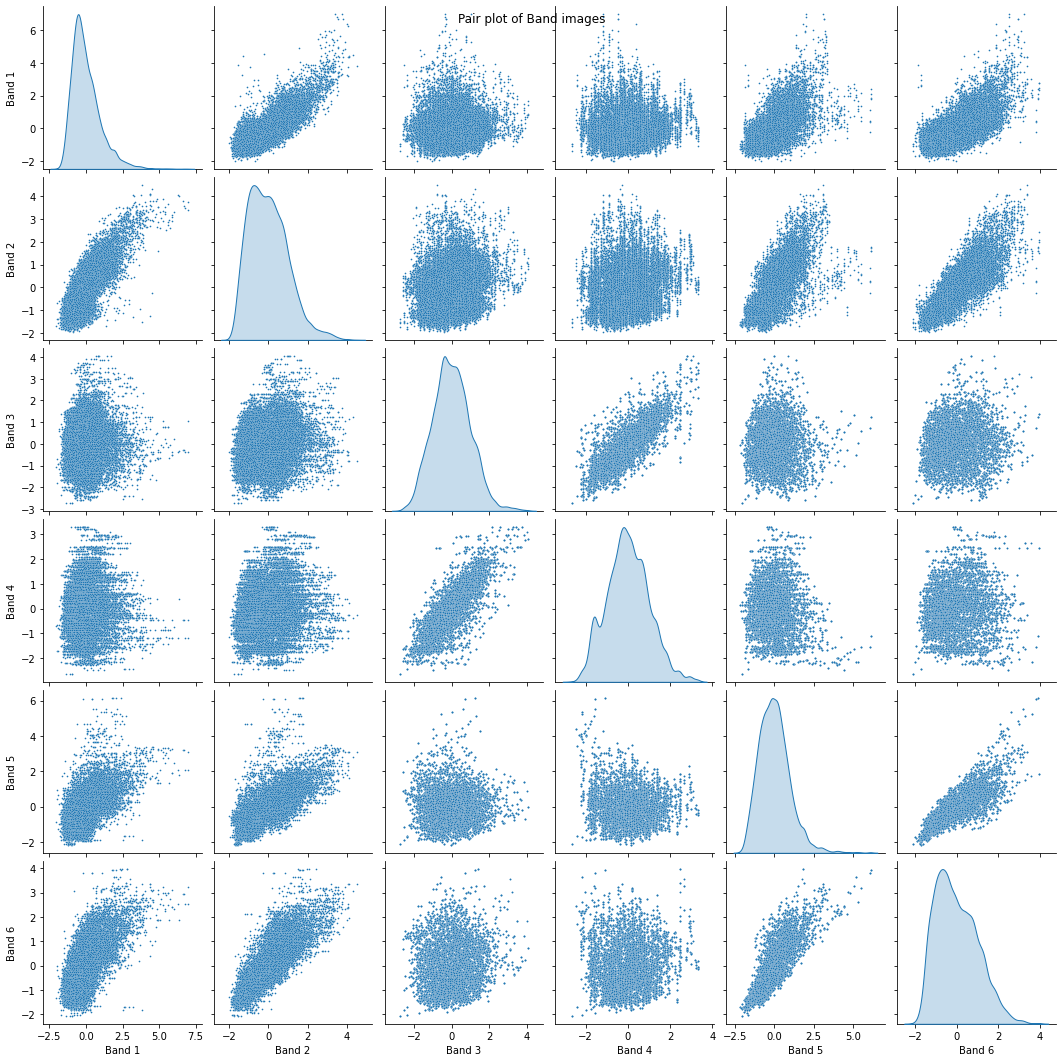

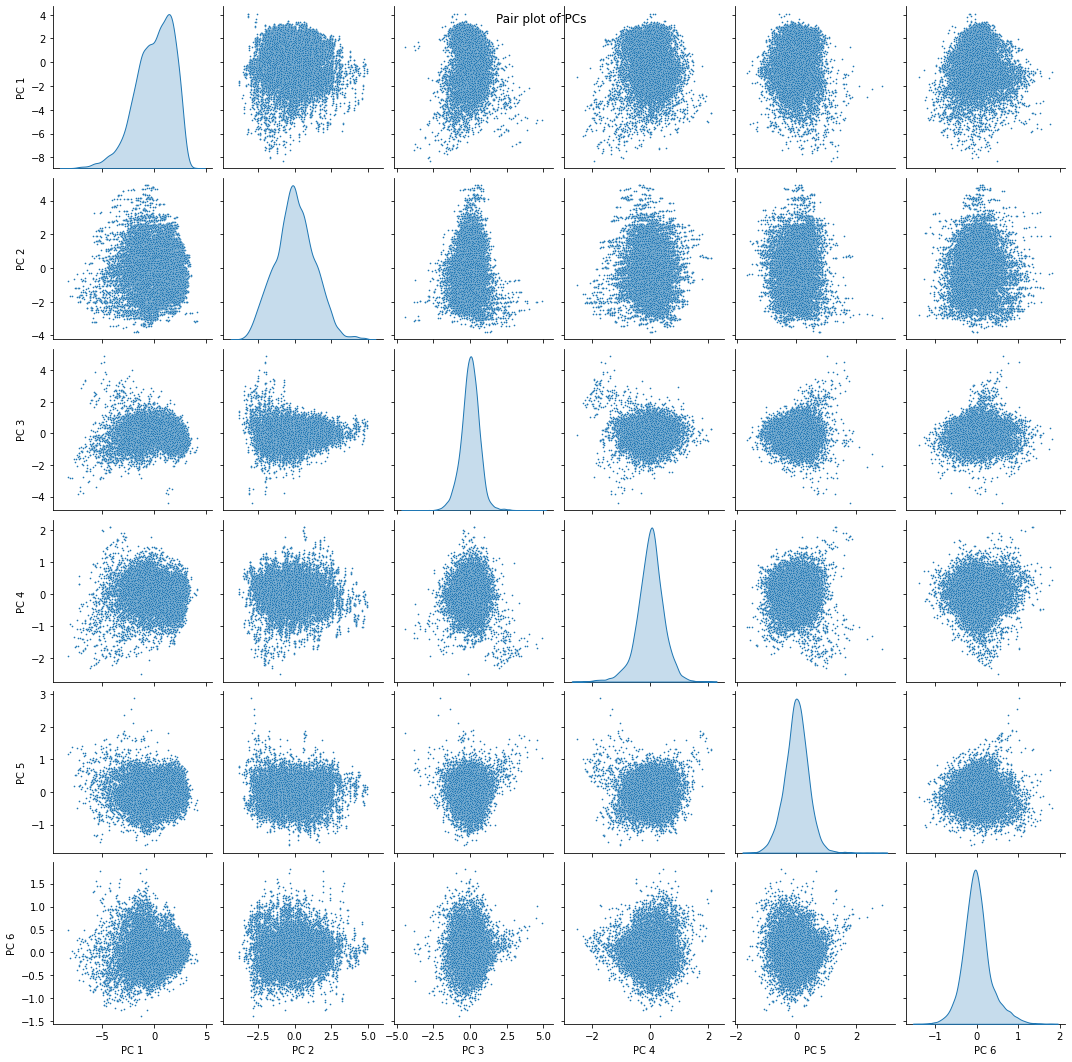

In [52]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Generate Pairplot for original data and transformed PCs
Bandnames = ['Band 1','Band 2','Band 3','Band 4','Band 5','Band 6']
PC = PCs[:,:,percentile_idx_selected,season_idx_selected]
MB = MB_matrix[:,:,percentile_idx_selected,season_idx_selected]
a = sns.pairplot(pd.DataFrame(MB,
                columns = Bandnames),
                 diag_kind='kde',plot_kws={"s": 3})
a.fig.suptitle("Pair plot of Band images")

PCnames = ['PC 1','PC 2','PC 3','PC 4','PC 5','PC 6']
PC = PCs[:,:,percentile_idx_selected,season_idx_selected]
b = sns.pairplot(pd.DataFrame(PC, columns = PCnames),
                 diag_kind='kde',plot_kws={"s": 3})
b.fig.suptitle("Pair plot of PCs")

#### 4.2 Compressibility Check

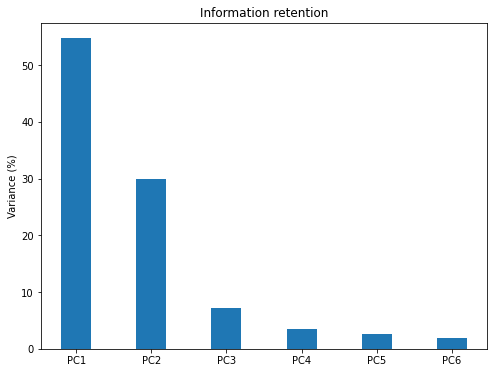

In [53]:
#Information Retained by Principal Components
EigVal = EigVals[:,percentile_idx_selected,season_idx_selected]

plt.figure(figsize=(8,6))
plt.bar([1,2,3,4,5,6],EigVal/sum(EigVal)*100,align='center',width=0.4,
        tick_label = ['PC1','PC2','PC3','PC4','PC5','PC6'])
plt.ylabel('Variance (%)')
plt.title('Information retention');

### 5. Converting PCs back to Images

In [54]:
import cv2
# Rearranging 1-d arrays to 2-d arrays of image size

PCs_2d = np.zeros((img_shape[0],img_shape[1],n_bands,n_percentiles,n_seasons))
for i in range (n_seasons):
    for j in range(n_percentiles):  
        for k in range(n_bands):
            PCs_2d[:,:,k,j,i] = PCs[:,k,j,i].reshape(-1,img_shape[1])

# normalizing between 0 to 255
PCs_2d_Norm = np.zeros((img_shape[0],img_shape[1],n_bands,n_percentiles,n_seasons))
for i in range (n_seasons):
    for j in range(n_percentiles):  
        for k in range(n_bands):
            PCs_2d_Norm[:,:,k,j,i] = cv2.normalize(PCs_2d[:,:,k,j,i],
                            np.zeros(img_shape),0,255 ,cv2.NORM_MINMAX)

### 6. Visualization

In [55]:
MB_img_idx_selected = MB_img[:,:,:,percentile_idx_selected,season_idx_selected]
MB_img_idx_selected.shape

(129, 129, 6)

In [56]:
PCs_2d_Norm_idx_selected = PCs_2d_Norm[:,:,:,percentile_idx_selected,season_idx_selected]
PCs_2d_Norm_idx_selected.shape

(129, 129, 6)

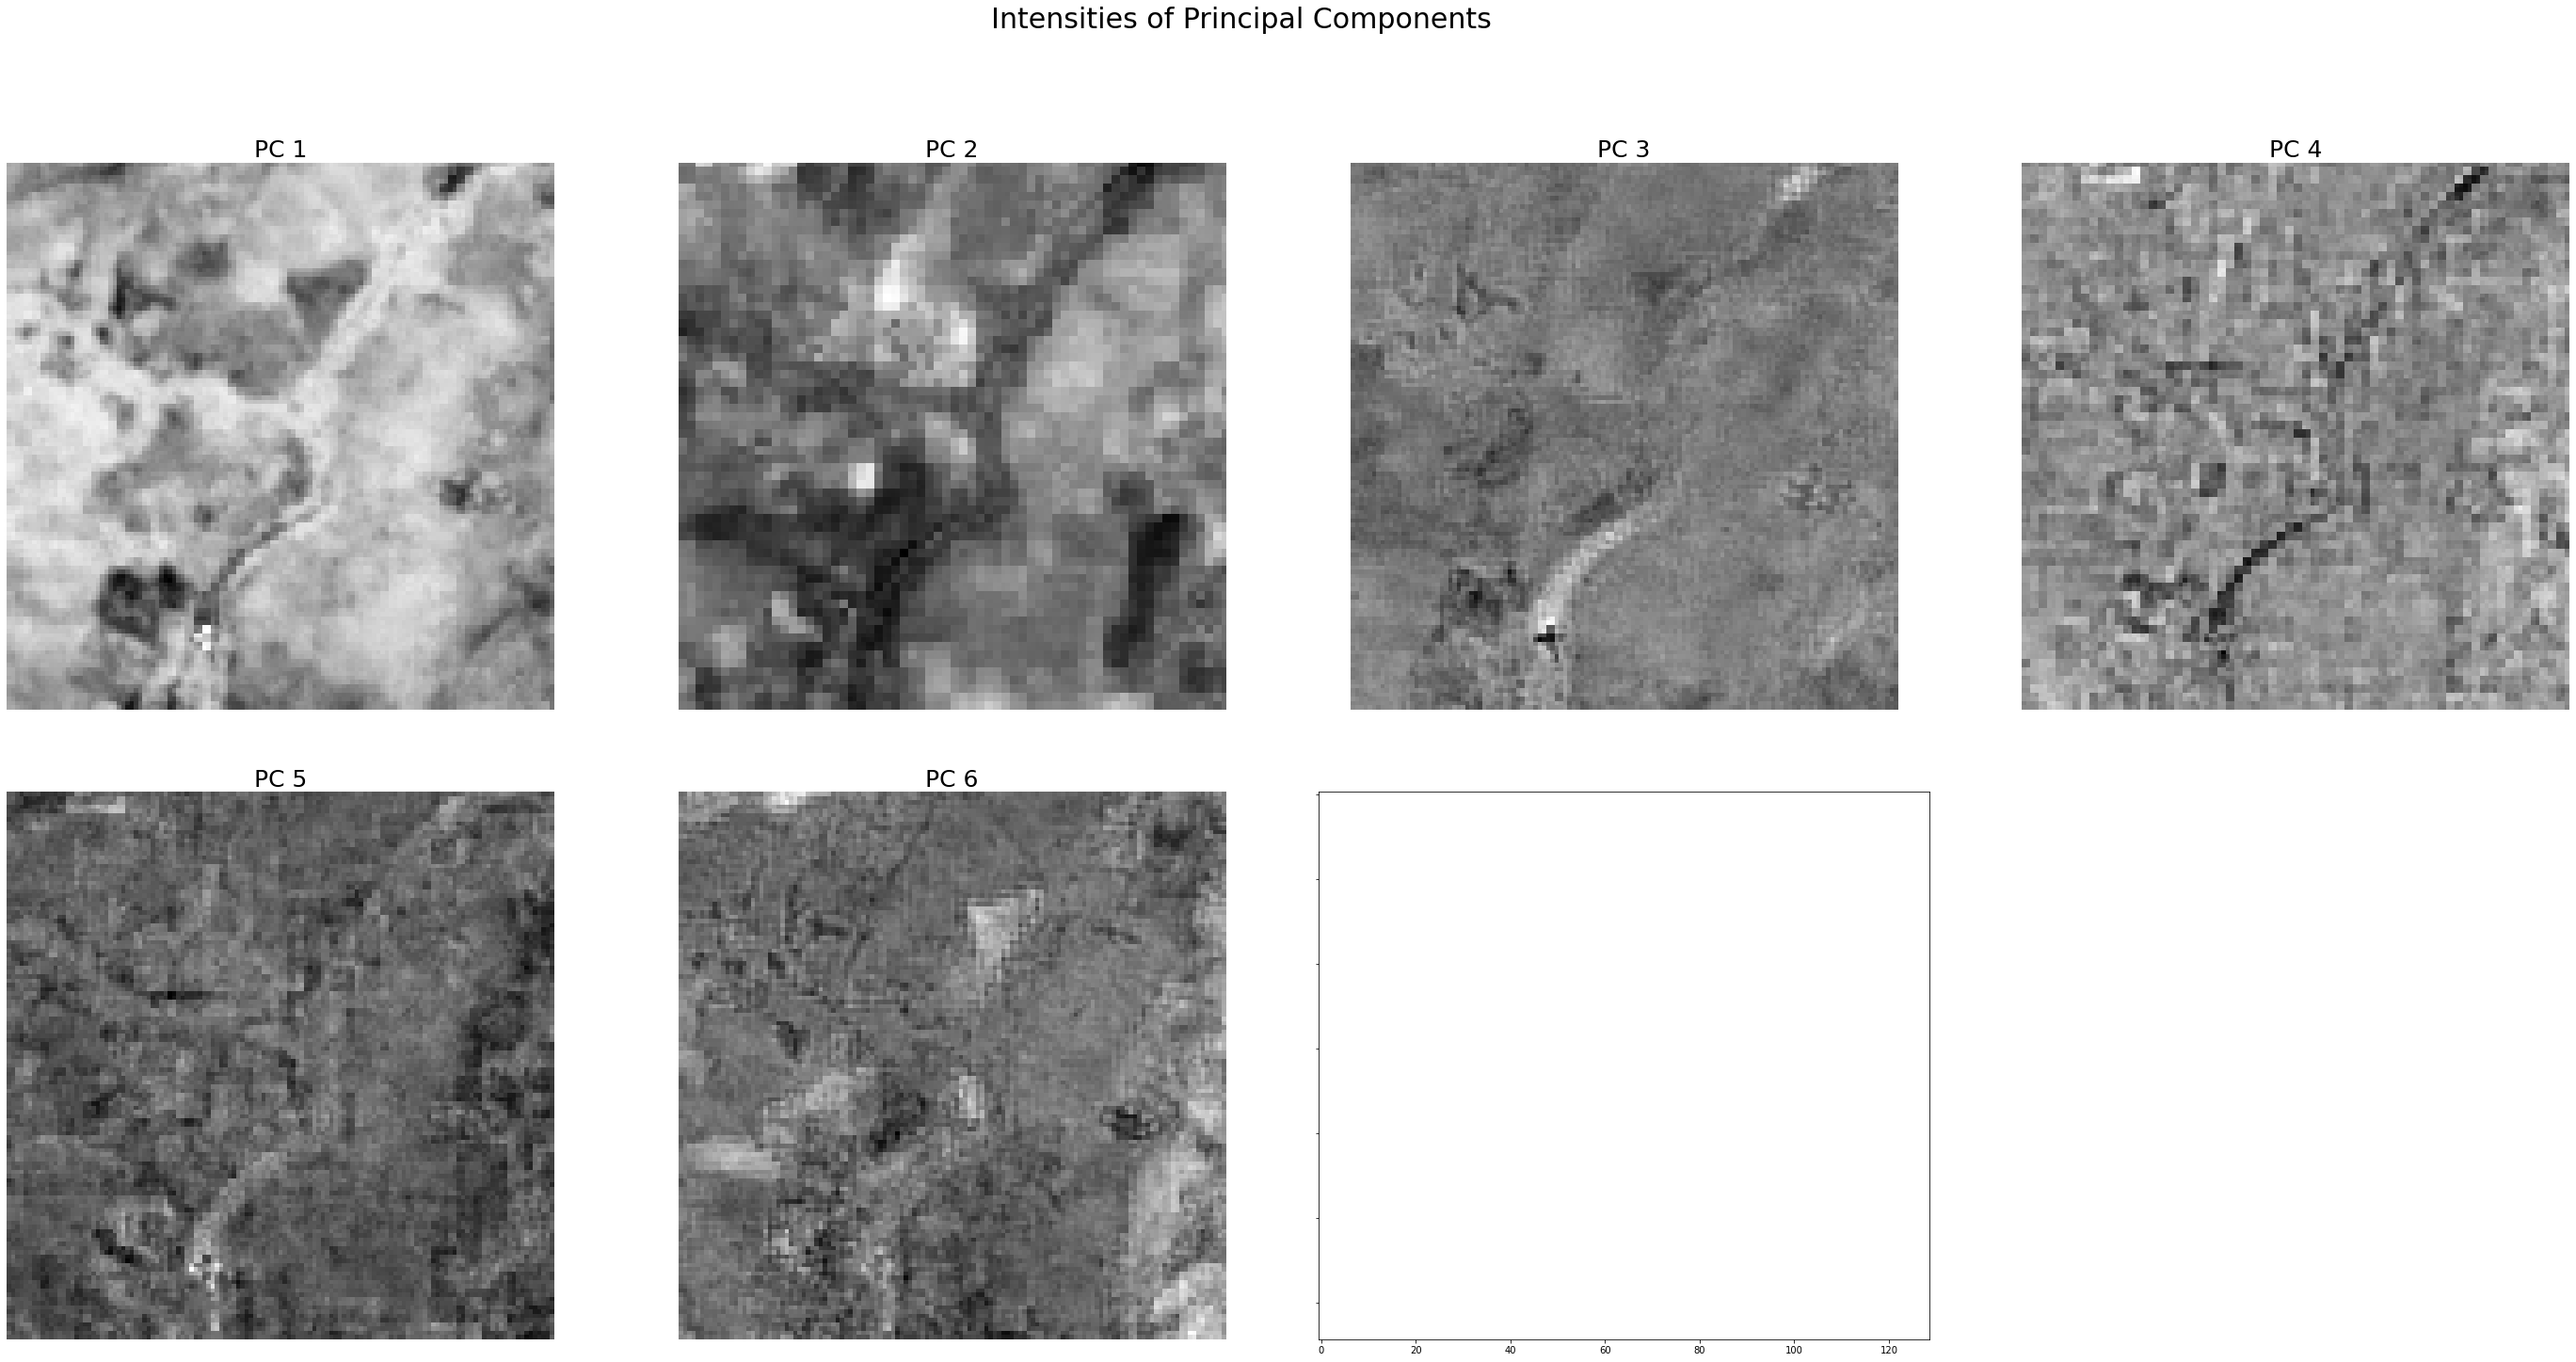

In [39]:
fig,axes = plt.subplots(2,4,figsize=(50,23),sharex='all',
                        sharey='all')
fig.subplots_adjust(wspace=0.1, hspace=0.15)
fig.suptitle('Intensities of Principal Components ', fontsize=30)

axes = axes.ravel()
for i in range(n_bands):
    # axes[i].imshow(MB_img_idx_selected[:,:,i], vmin=0, vmax=255)
    axes[i].imshow(PCs_2d_Norm_idx_selected[:,:,i],cmap='gray', vmin=0, vmax=255)
    # axes[i].imshow(PCs_2d_Norm_idx_selected[:,:,i],cmap='gray', vmin=0, vmax=255)
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')
fig.delaxes(axes[-1])

In [ ]:
chip.data.assign(new_test=chip.data["B02"])

In [ ]:
time_period = chip.data.coords['time_period'].data
metric = chip.data.coords['metric'].data
PC_1 = PCs_2d_Norm[:,:,0,:,:]
PC_2 = PCs_2d_Norm[:,:,1,:,:]
PC_3 = PCs_2d_Norm[:,:,2,:,:]
PC_4 = PCs_2d_Norm[:,:,3,:,:]
PC_5 = PCs_2d_Norm[:,:,4,:,:]
PC_6 = PCs_2d_Norm[:,:,5,:,:]
x = chip.data.coords['x'].data
y = chip.data.coords['y'].data

chip_pc = xr.Dataset(
    data_vars=dict(
        PC_1=(["x", "y", "metric", "time_period"], PC_1),
        PC_2=(["x", "y", "metric", "time_period"], PC_2),
        PC_3=(["x", "y", "metric", "time_period"], PC_3),
        PC_4=(["x", "y", "metric", "time_period"], PC_4),
        PC_5=(["x", "y", "metric", "time_period"], PC_5),
        PC_6=(["x", "y", "metric", "time_period"], PC_6),
    ),
    coords=dict(
        x=(["x"], x),
        y=(["y"], y),
        metric=metric,
        time_period=time_period,
    ),
    # attrs=dict(description="Weather related data."),
)
chip_pc = chips_loader.ChipS2(chip_pc, chip.df_scenes)
chip_pc

In [ ]:
def viz_compare_time_periods(
    self,
    bands=["B11", "B8A", "B04"],
    metrics=["p010", "p025", "p050", "p075", "p090", "pmid50", "pmid80"],
):

    fcc = (
        self.data[bands].sel(metric=metrics).to_array().rename({"variable": "band"})
    )
    fcc.plot.imshow(
        row="metric", col="time_period", rgb="band", robust=True, size=6
)

In [ ]:
# SWIR
chip_pc.viz_compare_time_periods(
    bands=["PC_1", "PC_2", "PC_3"],
    metrics=["p010", "p025", "p050", "p075", "p090", "pmid50", "pmid80"],
)

In [ ]:
# SWIR
chip_pc.viz_compare_time_periods(
    bands=["PC_4", "PC_5", "PC_6"],
    metrics=["p010", "p025", "p050", "p075", "p090", "pmid50", "pmid80"],
)

### Metadata - Sentinel 2 scenes

For each chip there is a metadata file containing information about the queried Sentinel 2 scenes. 
Those scenes were used to generate the metrics.

In [ ]:
print(chip.df_scenes.shape)
chip.df_scenes.head(2)

In [ ]:
chip.data

### Image data (metrics)

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/

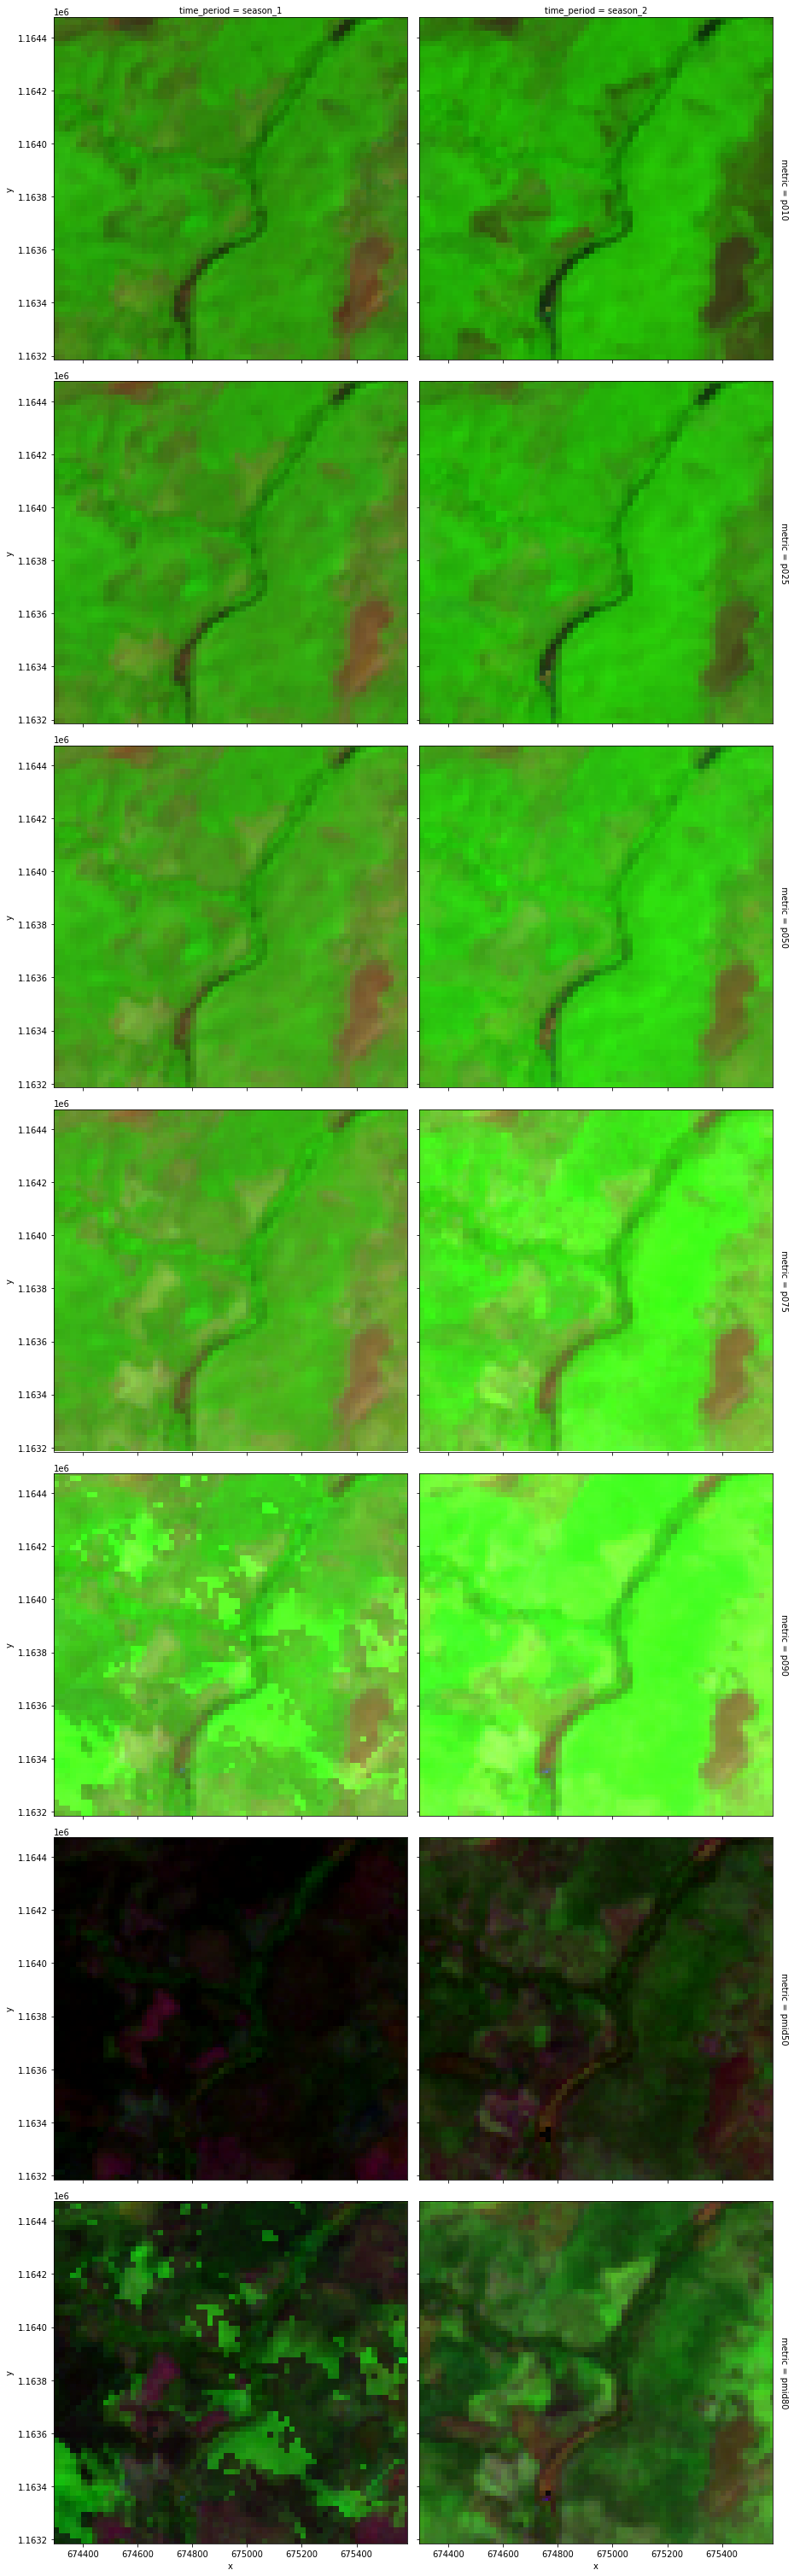

In [16]:
# SWIR
chip.viz_compare_time_periods(
    bands=["B12", "B8A", "B04"],
    metrics=["p010", "p025", "p050", "p075", "p090", "pmid50", "pmid80"],
)

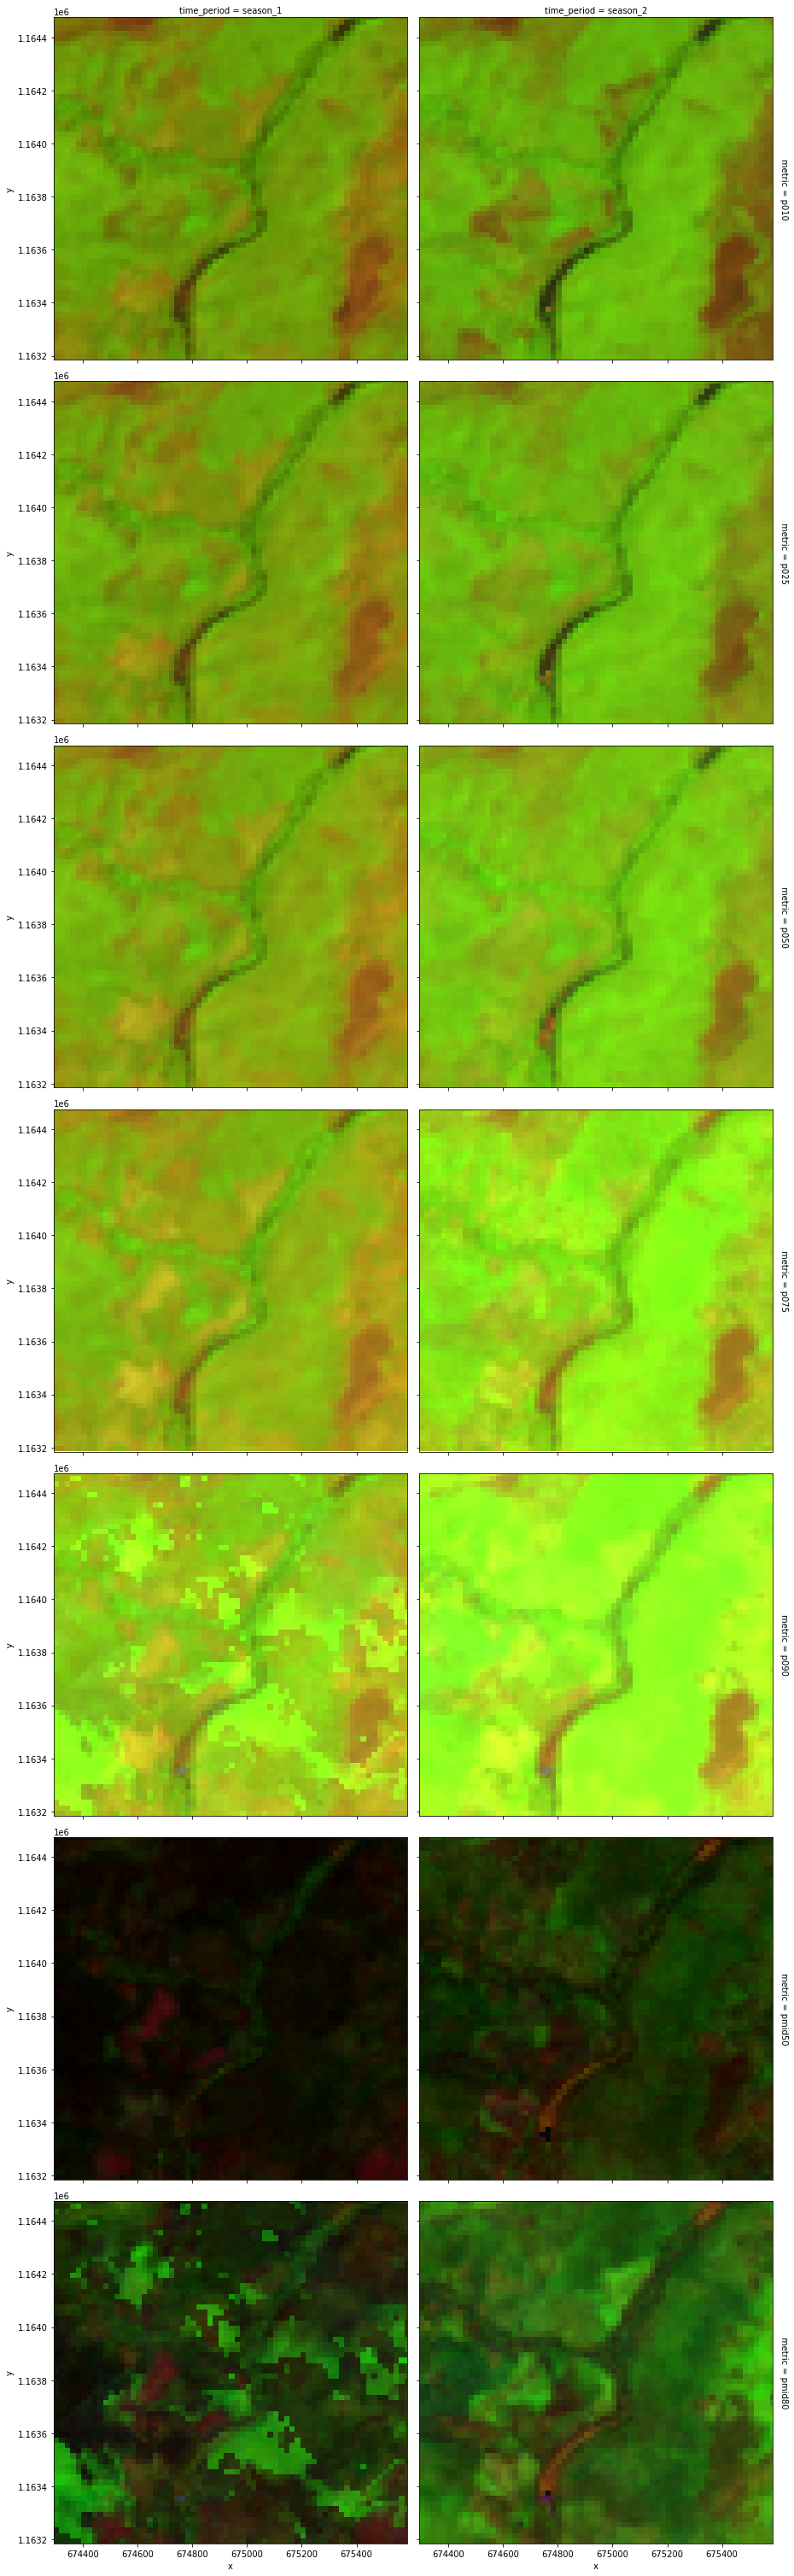

In [15]:
# Agriculture
chip.viz_compare_time_periods(
    bands=["B11", "B8A", "B02"],
    metrics=["p010", "p025", "p050", "p075", "p090", "pmid50", "pmid80"],
)